# MCMC1.5: How to Plot

## Plots.jl

In Julia, the most general framework for plotting is Plots.jl, which includes many backends. If you are used to Python, then Plots.jl should be overkill. Just call PyPlot.jl instead.

In [1]:
using Plots

Of course, PyPlot is also included in Plots.jl. However, it is the slowest choice in Julia.

In [2]:
pyplot()

Plots.PyPlotBackend()

The method `pyplot` will switch to the PyPlot.jl (if installed), but I won't use it today. Currently I recommend to use GR or PlotlyJS.

## PlotlyJS backend

PlotlyJS is faster but unstable. Sometimes it is difficult to build PlotlyJS while you are adding PlotlyJS.jl package.

In [3]:
plotlyjs()
#plot(x -> x ^ 2)

HTML{String}("    <script id=\"webio-setup-6288655682812273235\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-5532319470991282898\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-6288655682812273235\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/3ce8f986123371306a6e5ea10e913deba8b8ac88-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/3ce8f986123371306a6e5ea10e913deba8b8ac88-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-5532319470991282898\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

Plots.PlotlyJSBackend()

## GR backend

If you cannot install PlotlyJS.jl, the first choice must be the GR backend, which is fast and very stable. You can switch to gr by the method `gr`.

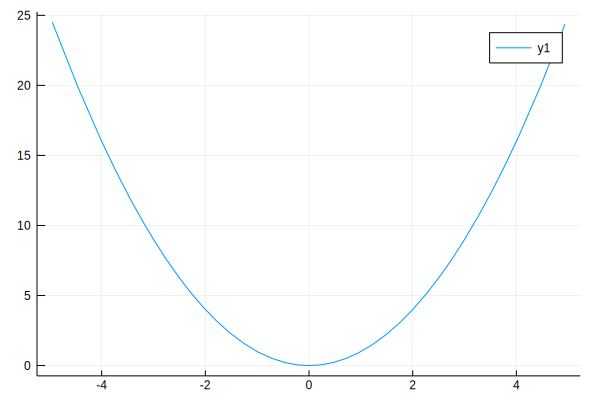

In [4]:
gr()
plot(x -> x ^ 2)

`plot!` will add another graph.

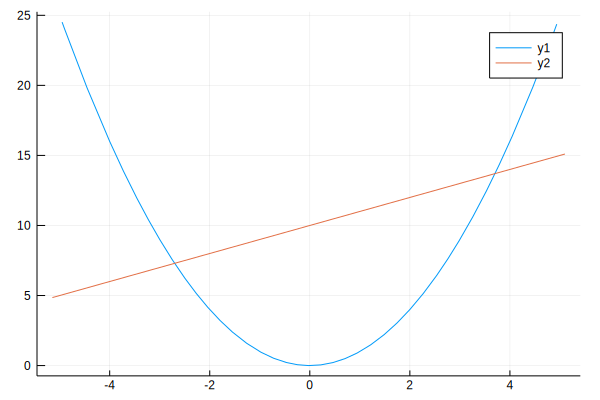

In [5]:
plot!(x -> x + 10)

For the speed test, see https://github.com/albi3ro/Plots.jl_Examples.

## Histogram

To see statistics graphically, you should check its histogram first.

In [6]:
using ResumableFunctions
@resumable function Ising1D()::Float64
    N = 1000
    σ = ones(Int64, N)
    β = 1.0
    step = 1
    while true
        for i in 1 : N
            j = rand(1 : N)
            ΔβE = 2β * σ[j] * (σ[mod1(j + 1, N)] + σ[mod1(j - 1, N)])
            -ΔβE > log(rand()) && (σ[j] = -σ[j])
        end
        if step > 10000
            @yield sum(σ) / N
        end
        step += 1
    end
end

Ising1D (generic function with 1 method)

For details of this code, see MCMC2.0 first. Let's just use the fact that `Ising1D()` returns an iterator, which iteratively produces magnetization samples of the 1D Ising model.

In [7]:
magnetization = Iterators.take(Ising1D(), 10000)

Base.Iterators.Take{getfield(Main, Symbol("##363"))}(getfield(Main, Symbol("##363"))(0x00, 6, #undef, 6, 6:0, 0, 0.0, 2.3539991923e-314, 4764547440, nothing, 4764568624), 10000)

`Iterators.take` will take the first 10000 samples of the magnetization. If you want them in the form of a vector, just collect. Isn't it cool? Note that currently the first part of iteration was discarded inside `Ising1D`, but you can discard them afterwards by `Iterators.drop`.

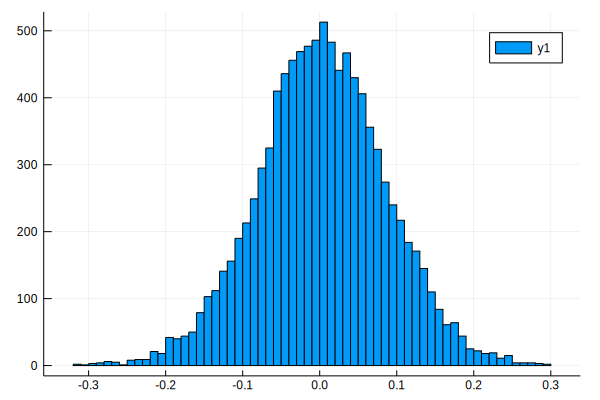

In [8]:
Mz = collect(magnetization)
histogram(Mz)

If it looks wierd, you can change binning.

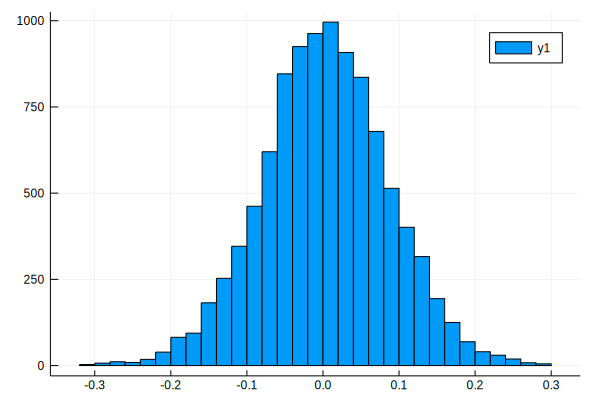

In [10]:
histogram(Mz, bins = 30)

## Scatter plot

The histogram was very easy. The scatter plot is easier.

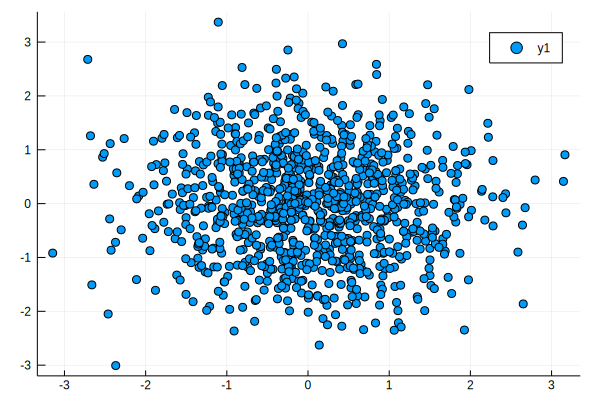

In [11]:
x = randn(1000)
y = randn(1000)
scatter(x, y)

This is a plot without correlation. In the correlated case,

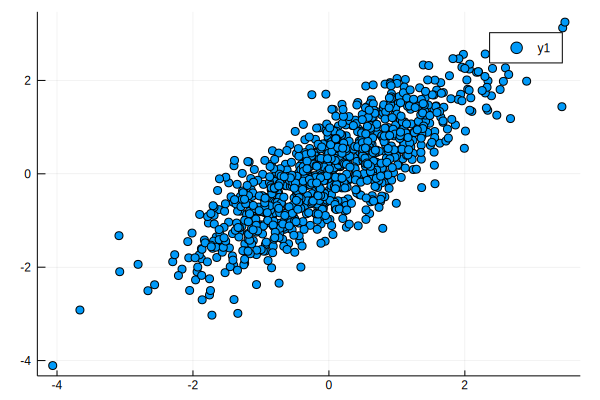

In [12]:
using Distributions
z = rand(MvNormal([0.0, 0.0], [1.0 0.8; 0.8 1.0]), 1000)
scatter(z[1, :], z[2, :])

Note that sending a matrix does not work because each column is regared as different data.

## Discrete distributions

### Discrete exponential distribution

So far, in this notebook we have treated continuous (or pseudo-continuous) distributions. In physics a crazy discrete distribution sometimes appears, especially when the number of flavors is large. Generating such distributions is not always easy, so I will show how. Here's a discrete version of the exponential distribution.

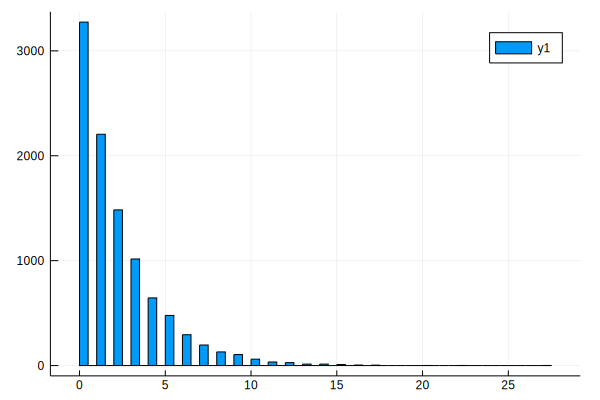

In [13]:
"""
Sample a natural number l from p(l) = exp(-ε l)

based on von Neumann's algorithm
"""
function discreteexponential(ε::Float64)::Int64
    if ε > 1.0
        throw(DomainError())
        return 0
    end
    l = 0
    while true
        Uold = ε
        Unew = rand()
        n = 1
        while Unew < Uold
            n += 1
            Uold = Unew
            Unew = rand()
        end
        if n & 1 == 0
            break
        end
        l += 1
    end
    l
end
de = [discreteexponential(0.4) for i in 1 : 10000]
histogram(de)

Here I used von Neumann's algorithm. Check http://exrandom.sourceforge.net/ for more details.

### Poisson distribution

Nothing to say about this distribution.

### Discrete normal distribution

This is tricky. Based on von Neumann's algorithm.

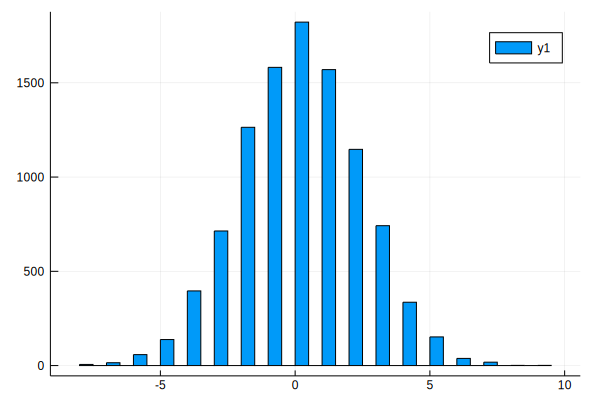

In [14]:
"""
Sample an integer l from p(l) = exp(-ε l²)

based on arXiv:1303.6257
"""
function discretenormal(ε::Float64)::Int64
    s = 1
    l = 0
    while true
        l = discreteexponential(ε)
        while rand() > exp(-ε * (l * (l - 1)))
            l = discreteexponential(ε)
        end
        s = rand([-1, 1])
        if (l != 0) || (s != -1)
            break
        end
    end
    l * s
end
dn = [discretenormal(0.1) for i in 1 : 10000]
histogram(dn)

**Exercise**: Rewrite these functions using recursion.

## Tips: animation

~ under construction ~